In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

import random
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

In [23]:
def cmatrix_fun(model_name, actual, predicted):
    # Compute confusion matrix
    cm = metrics.confusion_matrix(actual, predicted)
    
    # Normalize confusion matrix
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
    
    # Plot the normalized confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    class_labels = ['normal', 'mild', 'moderate', 'severe']
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")
    
    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_labels, yticklabels=class_labels,
           title=model_name,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'  # Format for the percentages
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
    
    plt.show()

In [24]:
def read_csv_file(file_path):
    try:
        return pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        return pd.read_csv(file_path, encoding='latin1')


def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

def Encoding(df):
    # Create the ncoder variable
    encoder = LabelEncoder()
    cat_df = df.select_dtypes(include=['object'])
    for i in cat_df:
        # fit the categoral feature to the encoding method
        df[i] = encoder.fit_transform(df[i]) 
    return df

def MissingValueHandling(merged_df):
    null_col =  dict(merged_df.isnull().sum()) 
    missing_data = []
    for key, value in null_col.items():
        if (value != 0):
            missing_data.append(key) 
    print("Missing Values Column:", null_col)
    for i in missing_data:
        fill_list = merged_df[i].dropna().tolist()
        merged_df[i] = merged_df[i].fillna(pd.Series(np.random.choice(fill_list , size = len(merged_df.index))))
    return merged_df
    
# Function to train and evaluate models
def train_and_evaluate(model, model_name, X_train_scaled, y_train, X_test_scaled, y_test):
    model.fit(X_train_scaled, y_train)
    train_accuracy = model.score(X_train_scaled, y_train) * 100
    test_accuracy = model.score(X_test_scaled, y_test) * 100
    # y_pred = model.predict(X_test_scaled)
    # accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Testing Accuracy: {test_accuracy:.2f}")
    # print(f"{model_name} Model Accuracy: {accuracy:.2f}")
    


def evaluate_classification_model(model, X_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Print the evaluation metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Plot the confusion matrix
    labels = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


## File Paths:

In [25]:
womac_path = "../csv/data_training/classify.csv"
features_path = "../csv/data_training/one-domain-only/freq.csv"

wdf = read_csv_file(womac_path)
fdf = read_csv_file(features_path)

fdf.columns = fdf.columns.str.strip()
wdf.columns = wdf.columns.str.strip()

assert 'patient_id' in fdf.columns, "'patient_id' not found in fdf columns"
assert 'patient_id' in wdf.columns, "'patient_id' not found in wdf columns"

fdf.head()
# wdf.head()

,patient_id,Omega_X_T,Omega_Y_T,Omega_Z_T,powerX_ 1_T,powerX_ 2_T,powerX_ 3_T,powerX_ 4_T,powerX_ 5_T,powerX_ 6_T,...,powerY_ 3_C,powerY_ 4_C,powerY_ 5_C,powerY_ 6_C,powerZ_ 1_C,powerZ_ 2_C,powerZ_ 3_C,powerZ_ 4_C,powerZ_ 5_C,powerZ_ 6_C
0,1,0.277935,0.463224,0.277935,180633.500100,2715.300595,1142.922594,2896.787766,4549.337418,1503.340223,...,1040.211971,73.481629,141.905164,10.216969,1.571939e+06,607.747259,533.161447,2633.837158,3055.918834,173.842186
1,1,0.167873,0.167873,0.167873,673479.552964,10462.490523,3510.894302,115.132022,7291.119140,757.157160,...,1964.301772,816.673624,404.261715,228.916362,2.954191e+06,109.416956,2606.851615,10.729508,5185.243035,25.271313
2,1,0.195043,0.390085,0.195043,152588.671876,3723.025206,859.737097,18048.560908,6436.578862,1714.642390,...,4199.071301,3488.940407,113.009892,760.522046,1.902485e+06,860.193745,304.164403,12119.034787,1532.932283,537.452090
3,10,0.326657,0.217771,0.217771,7734.323025,132.404792,2385.283110,1408.839371,2654.345195,1.621347,...,753.474303,535.838457,105.252777,182.907451,9.738762e+05,2350.306948,2954.338341,2614.545432,1978.834077,105.690189
4,10,0.855208,0.285069,0.570139,198751.014225,13694.723098,208.925145,2902.351579,3592.869586,716.090973,...,442.169719,431.027909,176.619568,75.768927,1.519685e+06,72.975955,462.167270,1289.025156,711.321877,26.048736


# Preprocessing:

## Merging two Dataframes

In [26]:
# Get the count of trials per patient
trials_counts = fdf['patient_id'].value_counts().to_dict()
print("trials:", trials_counts)
# Expand the anthropometric data
expanded_wdf = wdf.loc[
    wdf.index.repeat(wdf['patient_id'].map(trials_counts))
].reset_index(drop=True)
print("features df shape:", fdf.shape)
print("all df shape:", expanded_wdf.shape)

merged_df = pd.merge(fdf, wdf, on='patient_id', how='left')
merged_df.shape

trials: {11: 5, 17: 4, 18: 4, 23: 4, 22: 4, 21: 4, 20: 4, 7: 4, 8: 4, 6: 4, 16: 4, 15: 4, 14: 4, 13: 4, 12: 4, 5: 3, 1: 3, 2: 3, 3: 3, 10: 3, 19: 3, 9: 3, 4: 2}
features df shape: (84, 43)
all df shape: (84, 7)


(84, 49)

## Missing Data Handling

In [27]:
merged_df = MissingValueHandling(merged_df)
    
null_col =  np.array(merged_df.isnull().sum()) 
print("Missing values:", null_col)

Missing Values Column: {'patient_id': 0, 'Omega_X_T': 0, 'Omega_Y_T': 0, 'Omega_Z_T': 0, 'powerX_ 1_T': 0, 'powerX_ 2_T': 0, 'powerX_ 3_T': 0, 'powerX_ 4_T': 0, 'powerX_ 5_T': 0, 'powerX_ 6_T': 0, 'powerY_ 1_T': 0, 'powerY_ 2_T': 0, 'powerY_ 3_T': 0, 'powerY_ 4_T': 0, 'powerY_ 5_T': 0, 'powerY_ 6_T': 0, 'powerZ_ 1_T': 0, 'powerZ_ 2_T': 0, 'powerZ_ 3_T': 0, 'powerZ_ 4_T': 0, 'powerZ_ 5_T': 0, 'powerZ_ 6_T': 0, 'Omega_X_C': 0, 'Omega_Y_C': 0, 'Omega_Z_C': 0, 'powerX_ 1_C': 0, 'powerX_ 2_C': 0, 'powerX_ 3_C': 0, 'powerX_ 4_C': 0, 'powerX_ 5_C': 0, 'powerX_ 6_C': 0, 'powerY_ 1_C': 0, 'powerY_ 2_T.1': 0, 'powerY_ 3_C': 0, 'powerY_ 4_C': 0, 'powerY_ 5_C': 0, 'powerY_ 6_C': 0, 'powerZ_ 1_C': 0, 'powerZ_ 2_C': 0, 'powerZ_ 3_C': 0, 'powerZ_ 4_C': 0, 'powerZ_ 5_C': 0, 'powerZ_ 6_C': 0, 'name': 0, 'gender': 0, 'leg': 0, 'age': 3, 'BMI': 0, 'severity': 0}
Missing values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


## Encoding Categorical Data:

In [28]:
print('Severity before Encoding:')
print(dict(merged_df['severity'].value_counts()))

merged_df = Encoding(merged_df)
    
# # Check that the value transformed successfully 
print('Severity after Encoding:')
dict(merged_df['severity'].value_counts())

Severity before Encoding:
{'normal': 33, 'severe': 21, 'mild': 16, 'moderate': 14}
Severity after Encoding:


{2: 33, 3: 21, 0: 16, 1: 14}

## Drop Extra Columns and splitting data from target

In [29]:
merged_df.columns

Index(['patient_id', 'Omega_X_T', 'Omega_Y_T', 'Omega_Z_T', 'powerX_ 1_T',
       'powerX_ 2_T', 'powerX_ 3_T', 'powerX_ 4_T', 'powerX_ 5_T',
       'powerX_ 6_T', 'powerY_ 1_T', 'powerY_ 2_T', 'powerY_ 3_T',
       'powerY_ 4_T', 'powerY_ 5_T', 'powerY_ 6_T', 'powerZ_ 1_T',
       'powerZ_ 2_T', 'powerZ_ 3_T', 'powerZ_ 4_T', 'powerZ_ 5_T',
       'powerZ_ 6_T', 'Omega_X_C', 'Omega_Y_C', 'Omega_Z_C', 'powerX_ 1_C',
       'powerX_ 2_C', 'powerX_ 3_C', 'powerX_ 4_C', 'powerX_ 5_C',
       'powerX_ 6_C', 'powerY_ 1_C', 'powerY_ 2_T.1', 'powerY_ 3_C',
       'powerY_ 4_C', 'powerY_ 5_C', 'powerY_ 6_C', 'powerZ_ 1_C',
       'powerZ_ 2_C', 'powerZ_ 3_C', 'powerZ_ 4_C', 'powerZ_ 5_C',
       'powerZ_ 6_C', 'name', 'gender', 'leg', 'age', 'BMI', 'severity'],
      dtype='object')

In [30]:
merged_df = shuffle(merged_df, random_state=random_seed)

columns_to_drop = ['patient_id', 'name', 'leg', 'severity']

X = merged_df.drop(columns = columns_to_drop, axis = 1)  
y = merged_df['severity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train.shape

(67, 45)

# Feature Selection

## Filter Method

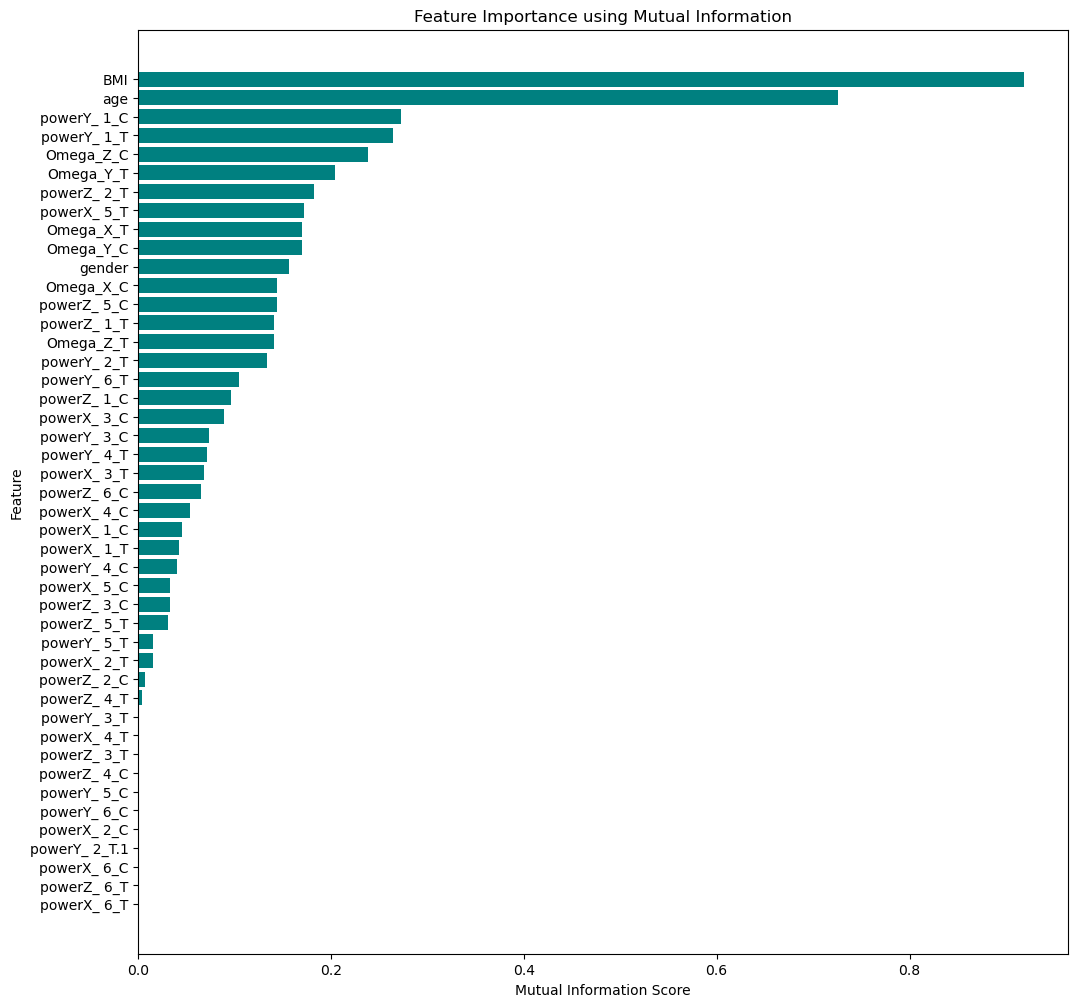

In [31]:
###################################################### Information Gain ######################################################
mi_scores = mutual_info_classif(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
# Sort features by their mutual information scores
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)
# mi_scores_df

# Plot feature importance
plt.figure(figsize=(12, 12))
plt.barh(mi_scores_df['Feature'], mi_scores_df['MI Score'], color='teal')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Feature Importance using Mutual Information')
plt.gca().invert_yaxis()  # To display the highest scores at the top

# Save the plot as an image
# plt.savefig('important_img/Gain_feature_importance.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [32]:
non_selected_features = []
for i in range(len(mi_scores_df["Feature"])):
    # print(mi_scores_df["Feature"][i])
    if mi_scores_df["MI Score"][i] == 0.000000:
        non_selected_features.append(mi_scores_df["Feature"][i])

non_selected_features

['powerX_ 4_T',
 'powerX_ 6_T',
 'powerY_ 3_T',
 'powerZ_ 3_T',
 'powerZ_ 6_T',
 'powerX_ 2_C',
 'powerX_ 6_C',
 'powerY_ 2_T.1',
 'powerY_ 5_C',
 'powerY_ 6_C',
 'powerZ_ 4_C']

### Drop unselected columns from filter method

In [33]:
X_train_filter = X_train.drop(non_selected_features, axis=1)
X_test_filter = X_test.drop(non_selected_features, axis=1)
X_train_filter.columns

Index(['Omega_X_T', 'Omega_Y_T', 'Omega_Z_T', 'powerX_ 1_T', 'powerX_ 2_T',
       'powerX_ 3_T', 'powerX_ 5_T', 'powerY_ 1_T', 'powerY_ 2_T',
       'powerY_ 4_T', 'powerY_ 5_T', 'powerY_ 6_T', 'powerZ_ 1_T',
       'powerZ_ 2_T', 'powerZ_ 4_T', 'powerZ_ 5_T', 'Omega_X_C', 'Omega_Y_C',
       'Omega_Z_C', 'powerX_ 1_C', 'powerX_ 3_C', 'powerX_ 4_C', 'powerX_ 5_C',
       'powerY_ 1_C', 'powerY_ 3_C', 'powerY_ 4_C', 'powerZ_ 1_C',
       'powerZ_ 2_C', 'powerZ_ 3_C', 'powerZ_ 5_C', 'powerZ_ 6_C', 'gender',
       'age', 'BMI'],
      dtype='object')

# Scaling Data

In [34]:
scaler_filter = StandardScaler()
X_train_filter = scaler_filter.fit_transform(X_train_filter)
X_test_filter = scaler_filter.transform(X_test_filter)

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training

## All Features

In [36]:
models_all = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models_all.items():
    train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score ({model_name}): {f1:.4f}")
    print('-' * 50)


Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 76.47
F1 Score (Random Forest): 0.7077
--------------------------------------------------
Logistic Regression Training Accuracy: 100.00
Logistic Regression Testing Accuracy: 88.24
F1 Score (Logistic Regression): 0.8850
--------------------------------------------------
KNN (k=7) Training Accuracy: 65.67
KNN (k=7) Testing Accuracy: 64.71
F1 Score (KNN (k=7)): 0.6534
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 88.24
F1 Score (XGBoost): 0.8850
--------------------------------------------------
linear SVM Training Accuracy: 100.00
linear SVM Testing Accuracy: 82.35
F1 Score (linear SVM): 0.8310
--------------------------------------------------
Poly SVM Training Accuracy: 61.19
Poly SVM Testing Accuracy: 47.06
F1 Score (Poly SVM): 0.3503
--------------------------------------------------
rbf SVM Training Accuracy: 89.55
rbf SVM Testing Accuracy: 70.59
F

In [37]:
# clf_all =  RandomForestClassifier(random_state=random_seed)
# clf_all.fit(X_train, y_train)

# y_pred_all_features = clf_all.predict(X_test)

# cmatrix_fun("Rf with ALL features", y_test, y_pred_all_features)

## Over Sampling

In [38]:
from imblearn.over_sampling  import RandomOverSampler
sampling_strategy = {
    0: 2500,
    1: 2500,
    2: 2500,
    3: 2500
    # Add more classes as needed
}

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize RandomOverSampler with the specified sampling strategy
smoteOver = RandomOverSampler(sampling_strategy=sampling_strategy)
# smoteOver = RandomOverSampler(sampling_strategy=1)
X_smoteOver, y_smoteOver = smoteOver.fit_resample(X_train , y_train)
print(f' X_shape: {X_smoteOver.shape} \n y_shape: {y_smoteOver.shape}')

# Initialize StandardScaler
# scaler_corr = StandardScaler()
# X_train_smote = scaler_corr.fit_transform(X_smoteOver)
# X_test_smote = scaler_corr.transform(X_test)



 X_shape: (10000, 45) 
 y_shape: (10000,)


In [39]:
models_sample = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models_sample.items():
    train_and_evaluate(model, model_name, X_smoteOver, y_smoteOver, X_test, y_test)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score ({model_name}): {f1:.4f}")
    print('-' * 50)

Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 88.24
F1 Score (Random Forest): 0.8750
--------------------------------------------------
Logistic Regression Training Accuracy: 100.00
Logistic Regression Testing Accuracy: 88.24
F1 Score (Logistic Regression): 0.8922
--------------------------------------------------
KNN (k=7) Training Accuracy: 100.00
KNN (k=7) Testing Accuracy: 47.06
F1 Score (KNN (k=7)): 0.4796
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 88.24
F1 Score (XGBoost): 0.8850
--------------------------------------------------
linear SVM Training Accuracy: 100.00
linear SVM Testing Accuracy: 70.59
F1 Score (linear SVM): 0.7196
--------------------------------------------------
Poly SVM Training Accuracy: 100.00
Poly SVM Testing Accuracy: 41.18
F1 Score (Poly SVM): 0.3654
--------------------------------------------------
rbf SVM Training Accuracy: 100.00
rbf SVM Testing Accuracy: 82.3

In [20]:
# clf_all =  RandomForestClassifier(random_state=random_seed)
# clf_all.fit(X_smoteOver, y_smoteOver)

# y_pred_sample = clf_all.predict(X_test)

# cmatrix_fun("Rf with ALL features", y_test, y_pred_sample)

## Feature selection training

In [21]:
models_filter = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models_filter.items():
    train_and_evaluate(model, model_name, X_train_filter, y_train, X_test_filter, y_test)
    y_pred = model.predict(X_test_filter)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score ({model_name}): {f1:.4f}")
    print('-' * 50)
    

Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 82.35
F1 Score (Random Forest): 0.8287
--------------------------------------------------
Logistic Regression Training Accuracy: 98.51
Logistic Regression Testing Accuracy: 58.82
F1 Score (Logistic Regression): 0.6475
--------------------------------------------------
KNN (k=7) Training Accuracy: 67.16
KNN (k=7) Testing Accuracy: 29.41
F1 Score (KNN (k=7)): 0.3053
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 82.35
F1 Score (XGBoost): 0.7993
--------------------------------------------------
linear SVM Training Accuracy: 98.51
linear SVM Testing Accuracy: 47.06
F1 Score (linear SVM): 0.5098
--------------------------------------------------
Poly SVM Training Accuracy: 71.64
Poly SVM Testing Accuracy: 52.94
F1 Score (Poly SVM): 0.5091
--------------------------------------------------
rbf SVM Training Accuracy: 97.01
rbf SVM Testing Accuracy: 70.59
F1 

In [21]:
# clf_filter =  RandomForestClassifier(random_state=random_seed)
# clf_filter.fit(X_train_filter, y_train)

# y_pred_filter = clf_filter.predict(X_test_filter)

# cmatrix_fun("Rf with ALL features", y_test, y_pred_filter)

## PCA selection

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


selector = RandomForestClassifier(n_estimators=100)
selector.fit(X_train, y_train)  
model_pca = SelectFromModel(selector, prefit=True)
data_selected = model_pca.transform(X_train)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(data_selected)

x1 = model_pca.transform(X_test)
X_test_pca = pca.transform(x1)

In [23]:
models_pca = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models_pca.items():
    train_and_evaluate(model, model_name, X_train_pca, y_train, X_test_pca, y_test)
    y_pred = model.predict(X_test_pca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score ({model_name}): {f1:.4f}")
    print('-' * 50)

Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 88.24
F1 Score (Random Forest): 0.8824
--------------------------------------------------
Logistic Regression Training Accuracy: 65.67
Logistic Regression Testing Accuracy: 70.59
F1 Score (Logistic Regression): 0.6556
--------------------------------------------------
KNN (k=7) Training Accuracy: 73.13
KNN (k=7) Testing Accuracy: 82.35
F1 Score (KNN (k=7)): 0.8329
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 82.35
F1 Score (XGBoost): 0.8223
--------------------------------------------------
linear SVM Training Accuracy: 68.66
linear SVM Testing Accuracy: 70.59
F1 Score (linear SVM): 0.7018
--------------------------------------------------
Poly SVM Training Accuracy: 58.21
Poly SVM Testing Accuracy: 76.47
F1 Score (Poly SVM): 0.7484
--------------------------------------------------
rbf SVM Training Accuracy: 76.12
rbf SVM Testing Accuracy: 76.47
F1 

In [24]:
# clf_pca =  RandomForestClassifier(random_state=random_seed)
# clf_pca.fit(X_train_pca, y_train)

# y_pred_pca = clf_filter.predict(X_test_pca)

# cmatrix_fun("Rf with ALL features", y_test, y_pred_pca)

## PCA on original data

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components= 30)  # Example: Retain 10 principal components
X_pca = pca.fit_transform(X_scaled)

FileNotFoundError: [Errno 2] No such file or directory: 'important_img/pca.png'

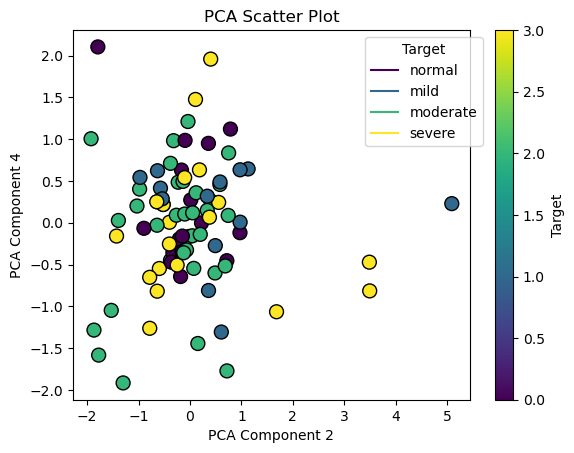

<Figure size 2000x2000 with 0 Axes>

In [26]:
scatter = plt.scatter(X_pca[:, 10], X_pca[:, 18], c=y, cmap='viridis', edgecolor='k', s=100)

# Create a legend with a color for each unique value in y
handles = [plt.Line2D([0,0],[0,0],color=scatter.cmap(scatter.norm(label))) for label in np.unique(y)]
class_labels = ['normal', 'mild', 'moderate', 'severe']
plt.legend(handles, class_labels, title='Target', bbox_to_anchor=(1.05, 1))

# Set plot title and axis labels
plt.title('PCA Scatter Plot')
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 4')

# Add a colorbar with a label
cbar = plt.colorbar(scatter)
cbar.set_label('Target')

# Adjust figure size and layout
plt.figure(figsize=(20, 20))
plt.tight_layout()
plt.savefig('important_img/pca.png', format='png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


In [ ]:
X_train_pca2, X_test_pca2, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=random_seed)

models_pca2 = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

for model_name, model in models_pca2.items():
    train_and_evaluate(model, model_name, X_train_pca2, y_train, X_test_pca2, y_test)
    y_pred = model.predict(X_test_pca2)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score ({model_name}): {f1:.4f}")
    print('-' * 50)